### Example code Pangea - Pondera Lab: data generation by entity (Aguascalientes, México)



* Install Python libraryes 

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 17.5 MB/s 
     |████████████████████████████████| 6.3 MB 33.1 MB/s 
     |████████████████████████████████| 16.7 MB 258 kB/s 


In [2]:
!pip install jenkspy

     |████████████████████████████████| 55 kB 2.3 MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=71212 sha256=977c8d7dae27114303f963b4f8cd2125e31d29b0a9ca43eda0eb6f40b15e1cb4
  Stored in directory: /root/.cache/pip/wheels/d8/d1/42/9bd05164ef706b84674905892f0542f8db6ac4a652473ca7e0
Successfully built jenkspy


In [3]:
!pip install feature_engine

     |████████████████████████████████| 205 kB 25.8 MB/s 
     |████████████████████████████████| 9.8 MB 45.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
!pip install fitter

     |████████████████████████████████| 47 kB 3.7 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=0e8c148ef0671426ff235694c89e23d58a9785bf31e988e4e4a03f9a679bc657
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=edeebf19116e43fa959aece37cfd5acd3084ebb77e82ac73d4d5879cb77801e0
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [5]:
!pip install imblearn

In [6]:
!pip install yellowbrick==0.9.1 scikit-learn==0.24 #22.2

     |████████████████████████████████| 282 kB 19.1 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 1.4
    Uninstalling yellowbrick-1.4:
      Successfully uninstalled yellowbrick-1.4


In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [8]:
import sys
sys.path.append('/content/gdrive/MyDrive/pamgea3_0')

### Stage 1

Segmentation of households from the ENIGH 2018 CONCENTRADOHOGAR base, the most important variables are selected and their natural cuts are obtained, thus building the *Segmentations of PANGEA*, this first part we create the `segmentation.csv` base that contains the information of the natural breaks (with the Jenks algorithm) of the important variables. This forms the segmentation or Tapestry, this base is modified in the second part to obtain a more ad-hoc segmentation.

In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import time

import geopandas as gpd

import joblib
import pickle
from joblib import dump, load

import warnings
warnings.simplefilter("ignore")

In [10]:
# Jenks
import jenkspy
from gvf import classify, goodness_of_variance_fit, percentage_class_members

# Funciones para obtener las bases de datos
from enigh_db2 import get_enigh
from census2 import fill_zeros,get_cvegeo,prepare_census

# Funiones para el pre proceso de los datos
from pre_proceso import FrecuentImputer, MeanImputer

### Data reading and exploratory analysis

Read the ENIGH and Census database for the appropriate state.

* The *get_enigh* function created in the *enigh_db* document, obtains the ENIGH base with the necessary features by joining the additional bases.
     The additional bases are poverty, IDH and municipalities (base created by us with information from the municipality).
     * The entire base can be ordered or just for one state.
     * Filter only for towns with >=2500 inhabitants.
     * The output is the base with the unions and the list of variables that are used for prediction.
     * These variables are those that are intercepted with the census.
* The function *prepare_census* of the document *census.py*, returns the census ready to be applied.

In [11]:
estado = 1 # state number (Aguascalientes, México)

pobreza = True 
idh = True
municipios = True

# Enigh
enigh, FEATURES = get_enigh(estado=estado, pobreza=pobreza, idh=idh, municipios=municipios)
enigh.shape

(1653, 246)

List of variables separated by their origin, If not all of them are used, the list of FEATURES can be changed.

In [12]:
municipios = ['huelgas_est', 'longitud_mun', 'calentador_sol', 'med_privad', 'separar_res', 'insi_trafico', 'por_jubilados', 'quehaceres_hog', 'pca3_mun',
              'conflictor_tr', 'latitud_mun', 'pca2_mun', 'pca1_mun', 'focos_ahorr']

idh = ['anios_esp_esc', 'indice_ingreso', 'indice_edu', 'mortalidad_inf', 'indice_salud', 'anios_prom_esc', 'ingreso_anual_capita', 'valor_idh']

pobreza = ['ingreso_inferior_lineabienmin', 'no_vul_no_pob', 'ingreso_inferior_lineabien', 'tres_carencia_social', 'carencia_basicos_viv',
           'carencia_calidad_vivienda', 'carencia_acceso_alimento', 'una_carencia_social', 'coeficiente_gini', 'pobre_extrema', 'carencia_acceso_salud',
           'pobre_moderada', 'carencia_acceso_segsocial', 'pobre', 'carencia_rezago_edu', 'vulnerable_social', 'vulnerable_ingreso']

coneval = ['ingreso_inferior_lineabien', 'tres_carencia_social', 'carencia_basicos_viv', 'indice_ingreso', 'indice_salud', 'pobre', 'ingreso_inferior_lineabienmin',
           'anios_esp_esc', 'mortalidad_inf', 'anios_prom_esc', 'vulnerable_social', 'no_vul_no_pob', 'carencia_calidad_vivienda', 'una_carencia_social',
           'coeficiente_gini', 'pobre_moderada', 'ingreso_anual_capita', 'valor_idh', 'vulnerable_ingreso', 'carencia_acceso_alimento', 'pobre_extrema',
           'carencia_acceso_salud', 'indice_edu', 'carencia_acceso_segsocial', 'carencia_rezago_edu']

#FEATURES = list(set(FEATURES) - set(pobreza+idh))

Loading the census base for the corresponding state

In [13]:
censo = prepare_census(estado=estado)
censo.shape

(15843, 126)

In [14]:
# Checking for duplicate values
enigh[['folioviv', 'foliohog']].drop_duplicates().shape, enigh.shape, censo['CVEGEO'].unique().shape, censo.shape

((1653, 2), (1653, 246), (15843,), (15843, 126))

### Clustering segmentation tapestry

Zeros in **current income**, which is the first variable to rank
* The number of zeros in the variable is printed.
* If there is at least one zero in the current input, the first cantile is added, so as not to have problems when doing the Box-Cox transformation

In [15]:
n_zeros = (enigh['ing_cor']==0).sum()
print('No. ceros: ',n_zeros)
if n_zeros>0:
    q_min = np.quantile(enigh['ing_cor'],0.01)
    print('Cuantil: ', q_min)
    enigh.loc[enigh['ing_cor']==0,'ing_cor'] = q_min

No. ceros:  0


*Apply the Box Cox transformation to normalize the data.*

In [16]:
xt = enigh['ing_cor'].values
#x = enigh['ing_cor'].values
"""pt = PowerTransformer(method='box-cox',standardize=False)
pt.fit(x.reshape(-1,1))
xt = pt.transform(x.reshape(-1,1)).reshape(-1)"""

enigh['ing_cor_t'] = xt

**Optional:** Caping to remove outlayers
* The values of the 0.01 quantile in current income are replaced by the previous value.

In [ ]:
"""from feature_engine.outliers import Winsorizer

capper = Winsorizer(capping_method='quantiles',fold=0.01,tail='both',variables='ing_cor')

enigh = capper.fit_transform(enigh)"""

"from feature_engine.outliers import Winsorizer\n\ncapper = Winsorizer(capping_method='quantiles',fold=0.01,tail='both',variables='ing_cor')\n\nenigh = capper.fit_transform(enigh)"

### Jenks Natural Breaks 

The metric used to evaluate how good the segmentation is is *Goodness of variance fit (GVF)*

*You can change the gvf (how well the variability is distributed).*

#### Variables de la ENIGH 

We use the variables **ing_cor** (current income), the variables **tot_integ** (household members), and **employed** (number of members who work) to carry out the Tapestry, are segmented at the national level.

In [ ]:
gvf = 0.0
nclasses = 1
while gvf < .97:
    nclasses += 1
    breaks = jenkspy.jenks_breaks(xt, nclasses)
    breaks = np.array(breaks)
    gvf = goodness_of_variance_fit(xt, breaks)
    ppc = percentage_class_members(xt,breaks)
    print('No. de clases: {} | GVF: {}'.format(nclasses,round(gvf,2)))
    print('Cortes naturales: ',[np.round(xx,2) for xx in breaks])
    #print('Cortes naturales escala original: ',[np.round(xx/60,2) for xx in pt.inverse_transform(breaks.reshape(-1,1)).reshape(-1)])
    print('Porcentaje de miembros por clase: {}\n'.format(ppc))

No. de clases: 2 | GVF: 0.58
Cortes naturales:  [1803.73, 91096.56, 477196.66]
Porcentaje de miembros por clase: [83.12, 16.88]

No. de clases: 3 | GVF: 0.78
Cortes naturales:  [1803.73, 64674.69, 154819.66, 477196.66]
Porcentaje de miembros por clase: [68.91, 26.68, 4.42]

No. de clases: 4 | GVF: 0.87
Cortes naturales:  [1803.73, 56553.19, 121278.68, 255815.53, 477196.66]
Porcentaje de miembros por clase: [61.52, 30.31, 7.38, 0.79]

No. de clases: 5 | GVF: 0.92
Cortes naturales:  [1803.73, 41896.21, 79121.3, 138191.02, 255815.53, 477196.66]
Porcentaje de miembros por clase: [43.8, 34.36, 15.85, 5.2, 0.79]

No. de clases: 6 | GVF: 0.94
Cortes naturales:  [1803.73, 38319.38, 69436.78, 108621.57, 163917.63, 273836.03, 477196.66]
Porcentaje de miembros por clase: [38.11, 34.85, 16.58, 6.72, 3.02, 0.73]

No. de clases: 7 | GVF: 0.96
Cortes naturales:  [1803.73, 32685.23, 56092.65, 86171.66, 131431.74, 194219.3, 292889.77, 477196.66]
Porcentaje de miembros por clase: [30.01, 31.03, 20.27, 1

By selecting the number of cuts, 6 cuts will be used, but you can:
* Using more cuts and joining some segments
* Using the 6 cuts given by Jenks

In [17]:
nclasses = 8
breaks_ing_cor = jenkspy.jenks_breaks(xt, nclasses)
breaks_ing_cor = np.array(breaks_ing_cor)

Current income histogram with selected cutoffs

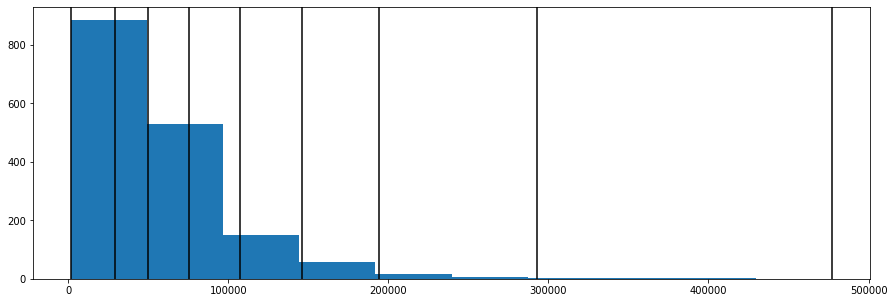

In [18]:
plt.figure(figsize=[15,5])
plt.hist(xt)
for v in breaks_ing_cor:
    plt.axvline(v,color='black')
plt.show()

Percentage of elements in each cut.

In [19]:
def find_segment(value,intervals_list): 
    n = len(intervals_list)
    segment = np.nan
    for j in range(1,n-1):
        if value<=intervals_list[j]:
            segment = j-1
            break
        elif value<=intervals_list[j+1]:
            segment = j
            break
    if value<intervals_list[0]:
        segment = np.nan
    return segment

enigh['ing_cor_t_segment'] = enigh['ing_cor_t'].apply(find_segment,args=(breaks_ing_cor,))

(enigh['ing_cor_t_segment'].value_counts(normalize=True)*100).sort_index()

0    23.714459
1    30.671506
2    21.839080
3    13.067151
4     5.505142
5     3.448276
6     1.209921
7     0.544465
Name: ing_cor_t_segment, dtype: float64

segment reassignment

In [20]:
enigh['ing_cor_t_segment'] = enigh['ing_cor_t_segment'].replace({6:5, 7:5, 8:5})#, 9:5

(enigh['ing_cor_t_segment'].value_counts(normalize=True)*100).sort_index()

0    23.714459
1    30.671506
2    21.839080
3    13.067151
4     5.505142
5     5.202662
Name: ing_cor_t_segment, dtype: float64

Fixing the segments to save them

In [21]:
# copying the first values
breaks_ing_cor_new = breaks_ing_cor[0:7].copy()
# copying the first values
breaks_ing_cor_new[0] = 0
# The last segment ends in the largest value, actually any larger value
breaks_ing_cor_new[-1] = breaks_ing_cor[-1] + 100000

for i in range(len(breaks_ing_cor_new)-1):
  print('Segmento: ', i, ' --- Intervalo: [{}, {}]'.format(breaks_ing_cor_new[i], breaks_ing_cor_new[i+1]))


Segmento:  0  --- Intervalo: [0.0, 29144.25]
Segmento:  1  --- Intervalo: [29144.25, 50001.69]
Segmento:  2  --- Intervalo: [50001.69, 75652.66]
Segmento:  3  --- Intervalo: [75652.66, 107041.4]
Segmento:  4  --- Intervalo: [107041.4, 146081.62]
Segmento:  5  --- Intervalo: [146081.62, 577196.6599999999]


** save archives

In [22]:
breaks_dic = {'breaks_ingreso':breaks_ing_cor_new}

nombre = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/breacks/ingreso_estado'+str(estado)+'.json'
joblib.dump(breaks_dic, nombre)

# joblib.load(nombre)

['/content/gdrive/MyDrive/pamgea3_0/pangea3_2/breacks/ingreso_estado1.json']

### Stage 2

* Applying the classification supervised learning model to the variable **ing_cor_t_segment**
* The variables that are found both in the census bases and in the enigh are used, adding information on Idh, Poverty, municipalities (Denue).

Checking if there is null data in any variable

In [ ]:
enigh.isnull().sum().sort_values(ascending=False)

folioviv             0
p5_hli_he            0
pcon_disc            0
pcdisc_mot           0
pcdisc_vis           0
                    ..
salud                0
atenc_ambu           0
hospital             0
medicinas            0
ing_cor_t_segment    0
Length: 248, dtype: int64

In [ ]:
censo.isnull().sum().sort_values(ascending=False)

vph_cel           2395
vph_autom         2395
vph_snbien        2395
vph_sincint       2395
vph_sinltc        2395
                  ... 
indice_ingreso       0
indice_salud         0
indice_edu           0
mortalidad_inf       0
tothog               0
Length: 126, dtype: int64

Preprocessing the variables:
* Removing null values in some census variables
* For the INT_FEATURES variables, the large values in the census base are delimited and replaced by the highest value found in the enigh.\
     (This is done because the census uses a synthetic household that is the average, so the average should not be greater than the maximum.)
* The variable is printed, the average of the variables above the maximum in the enigh and the amount of data that exceeds that limit.


In [ ]:
# If the value in the census is greater than the maximum of the enigh, it is bounded.
INT_FEATURES = [
    'tot_integ',
    'ocupados',
    'menores',
    'p65mas',
    'hombres',
    'mujeres',
    'mayores',
    'p12_64'
    ]

censo = censo.dropna(subset=INT_FEATURES).reset_index(drop=True)

for c in INT_FEATURES:
        censo[c] = censo[c].apply(lambda x: np.ceil(x) if np.modf(x)[0]>=0.5 else np.floor(x))
        censo[c] = censo[c].replace({np.inf:0})
        censo[c] = censo[c].astype(int)

for c in INT_FEATURES: 
    mmax = enigh[c].max() 
    e_stat = enigh[c].max()
    e_stat = np.ceil(e_stat) if np.modf(e_stat)[0]>=0.5 else np.floor(e_stat) # integer
    # modf: Return the fractional and integral parts of an array
    print(c,': ',np.round((censo[c]>mmax).mean()*100,4),(censo[c]>mmax).sum())
    censo.loc[censo[c]>mmax,c] = e_stat

tot_integ :  0.0 0
ocupados :  0.0 0
menores :  0.0 0
p65mas :  0.0 0
hombres :  0.0 0
mujeres :  0.0063 1
mayores :  0.0063 1
p12_64 :  0.0063 1


Creating a new variable

In [ ]:
enigh['tot_ocu'] = enigh['ocupados']/enigh['tot_integ']
censo['tot_ocu'] = censo['ocupados']/censo['tot_integ']

In [ ]:
FEATURES = FEATURES+['tot_ocu']

### Adding pre-processing so there is no null data in the census

In [ ]:
# categorical variables
categ = ['sexo_jefe', 'vph_telef', 'vph_cel', 'vph_inter', 'vph_stvp', 'vph_autom', 'vph_moto', 'vph_bici', 'vph_radio',
        'vph_tv', 'vph_lavad', 'vph_refri', 'vph_hmicro', 'vph_pc', 'vph_cvj', 'vph_ndacmm', 'vph_snbien', 'vph_sinrtv',
        'vph_sinltc', 'vph_sincint', 'pea', 'pder_segp', 'pder_ss', 'pder_imss', 'pder_istee','vph_pisodt', 'vph_pisoti', 'vph_1dor',
        'vph_2ymasd', 'vph_1cuart', 'vph_2cuart', 'vph_3ymasc', 'vph_aguadv', 'vph_excsa', 'vph_tinaco', 'vph_cister', 
        'vph_drenaj', 'vph_c_elec','huelgas_est']   # list(set() - set(pobreza+idh))

# Poverty and HDI variables
pob_idh =['pobre', 'pobre_moderada', 'pobre_extrema', 'vulnerable_social', 'vulnerable_ingreso', 'no_vul_no_pob',
          'una_carencia_social', 'tres_carencia_social', 'carencia_rezago_edu', 'carencia_acceso_salud',
          'carencia_acceso_segsocial', 'carencia_calidad_vivienda', 'carencia_basicos_viv', 'carencia_acceso_alimento',
          'ingreso_inferior_lineabien', 'ingreso_inferior_lineabienmin', 'coeficiente_gini', 'anios_esp_esc',
          'ingreso_anual_capita', 'mortalidad_inf', 'indice_edu', 'indice_salud', 'indice_ingreso', 'valor_idh']

# Those that necessarily have to be applied log
log_seg = ['por_jubilados']

# log 
log_pos = ['mayores', 'p15ym_an', 'pca1_mun', 'pca3_mun', 'pca2_mun', 'mujeres', 'anios_prom_esc', 'ocupados']

# Jeo o Box Cox 
inv = ['quehaceres_hog', 'focos_ahorr', 'med_privad', 'separar_res', 'pca1_mun', 'p12_64', 'tot_integ', 'insi_trafico', 'hombres',
        'conflictor_tr', 'pob15_64']

continuas = list(set(FEATURES)-set(categ))

Null values

In [ ]:
# Studying the number of missing data by categorical variable

enigh = enigh.replace([np.inf, -np.inf], np.nan)

cat_vars_with_na = [
    var for var in categ
    if enigh[var].isnull().sum() > 0
]

# print percentage of missing values per variable
enigh[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
censo[list(set(FEATURES)-set(categ))].isnull().sum().sum()

2395

In [ ]:
# Passing infinite values to null
enigh = enigh.replace([np.inf, -np.inf], np.nan)
#enigh[categ] = enigh[categ].fillna("Missing")
#enigh[categ] = enigh[categ].astype('O')
    
censo = censo.replace([np.inf, -np.inf], np.nan)
#censo[categ] = censo[categ].fillna("Missing")
#censo[categ] = censo[categ].astype('O')

Separating training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X = enigh[FEATURES]
y = enigh[['ing_cor_t_segment']]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

X_train.shape, X_test.shape

((1239, 125), (414, 125))

Training the classification algorithm to predict *ing_cor_t_segment*, on the variables found above, using the ENIGH base.

* Pre-processing to variables
     * Treat null data
     * Encoding the categorical data (not always necessary)
     * Transformation to variables
     * Scale the data (in case it is necessary for the model)
* Balance the data if the model does not
* Apply a classification model (good results have been obtained with RF, but you can change the model)
* Optimize hyper parameters:
     * Under F1 or Recall macro

Note: For best results, for example, {0:5, 1:5, 2:5, 3:4, 4:3, 5:4}

In [ ]:
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 

# feature engenearing
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
#from sklearn.impute import SimpleImputer,IterativeImputer
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine import transformation as vt
from sklearn.preprocessing import StandardScaler

# feature selectio 
from sklearn.feature_selection import RFE

# Model
#from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from imblearn.over_sampling import RandomOverSampler 
from sklearn.ensemble import RandomForestClassifier
#from imblearn.ensemble import BalancedRandomForestClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Procesing
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder


start = time.time()

model1 = RandomForestClassifier(random_state=42)
#model2 = BalancedRandomForestClassifier(random_state=42)


params = {
    # Feature selection
    'feature_sel__n_features_to_select':np.linspace(10, 40, 20).astype(int).tolist(),
    # Model
    'classifier__n_estimators':np.linspace(start = 50, stop = 2000, num = 20).astype(int).tolist(), 
    'classifier__max_depth':[None]+np.linspace(5, 110, num = 15).astype(int).tolist(), 
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf':[1, 2, 4, 10],
    'classifier__bootstrap': [True, False],
    'classifier__max_features':['auto','sqrt'],
    'classifier__criterion':['gini','entropy']
}


pipe = Pipeline([
    # Mising imputation
    ('categorical_imputer', FrecuentImputer(variables = categ)),
    ('median_imputer', MeanImputer(variables = continuas)),
    # Fearute selection
    ('feature_sel', RFE(estimator = model1)),
    # Model
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight={0:5, 1:4, 2:5, 3:5, 4:20, 5:10})), #
])
clf = RandomizedSearchCV(pipe,
                         params,
                         n_iter=5, # Iteration number
                         n_jobs=-1,
                         scoring='f1_weighted',#'recall_macro'
                         random_state=42)


clf.fit(X_train.astype(float), y_train.values.reshape(-1))
print(clf.best_score_)

end = time.time()
print('Running time: {:.2f} minutes'.format((end-start)/60))

0.38496798747205196
Running time: 8.90 minutes


In [ ]:
clf.best_params_

{'classifier__bootstrap': False,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 42,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 1178,
 'feature_sel__n_features_to_select': 38}

In [ ]:
selector = RFE(estimator = model1, n_features_to_select=38)
selector.fit(X_train, y_train)
X_train.columns[selector.support_]

Index(['tot_integ', 'ocupados', 'menores', 'hombres', 'mujeres', 'mayores',
       'p12_64', 'vph_telef', 'vph_inter', 'vph_stvp', 'vph_autom', 'vph_bici',
       'vph_radio', 'vph_hmicro', 'vph_pc', 'vph_ndacmm', 'vph_sincint',
       'p_8a14', 'p_18a24', 'p_60ymas', 'pob0_14', 'pob15_64', 'pcon_disc',
       'p15ym_an', 'p15ym_se', 'pea', 'pder_ss', 'pder_imss', 'pder_istee',
       'p12ym_solt', 'pocupada', 'pocupada_f', 'pocupada_m', 'vph_cister',
       'longitud_mun', 'vulnerable_social', 'coeficiente_gini', 'tot_ocu'],
      dtype='object')

In [ ]:
print('idh:', set(idh).intersection(set(X_train.columns[selector.support_])))
print('\n Pobreza:', set(pobreza).intersection(set(X_train.columns[selector.support_])))
print('\n Municipios:', set(municipios).intersection(set(X_train.columns[selector.support_])))

idh: set()

 Pobreza: {'coeficiente_gini', 'vulnerable_social'}

 Municipios: {'longitud_mun'}


Metrics and confusion matrices, pay more attention to the figures.

* The differences between the confusion matrices is the way they are normalized:
     * All: Among the total elements (Acuracy)
     * Predict: (Presition)
     * True: Each row / total row (Recall)


TRAIN
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       284
           1       0.99      0.95      0.97       386
           2       0.99      0.98      0.98       272
           3       0.99      0.99      0.99       166
           4       0.97      1.00      0.98        65
           5       0.97      1.00      0.99        66

    accuracy                           0.98      1239
   macro avg       0.98      0.99      0.98      1239
weighted avg       0.98      0.98      0.98      1239

TEST
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       108
           1       0.50      0.49      0.50       121
           2       0.34      0.35      0.34        89
           3       0.27      0.34      0.30        50
           4       0.10      0.08      0.09        26
           5       0.24      0.20      0.22        20

    accuracy                           0.45       414
   macro avg

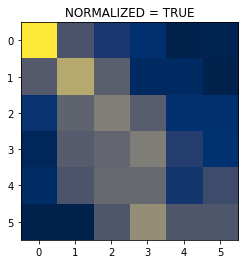

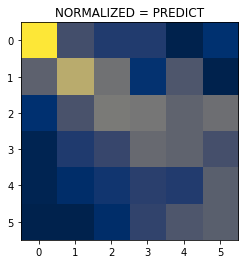

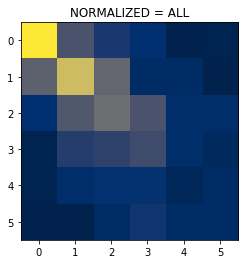

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('TRAIN')
cr = classification_report(y_train,y_train_pred)
print(cr)

print('TEST')
cr = classification_report(y_test,y_test_pred)
print(cr)


cm = confusion_matrix(y_test,y_test_pred,normalize='true')
plt.figure()
plt.title('NORMALIZED = TRUE')
plt.imshow(cm,cmap='cividis')
plt.show()

cm = confusion_matrix(y_test,y_test_pred,normalize='pred')
plt.figure()
plt.title('NORMALIZED = PREDICT')
plt.imshow(cm,cmap='cividis')
plt.show()

cm = confusion_matrix(y_test,y_test_pred,normalize='all')
plt.figure()
plt.title('NORMALIZED = ALL')
plt.imshow(cm,cmap='cividis')
plt.show()

Comparing the number of elements in the test base for each of the classes, training vs real.

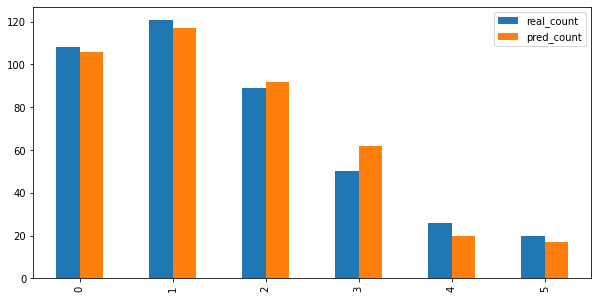

In [ ]:
real_segment_vc = y_test['ing_cor_t_segment'].value_counts()
pred_segment_vc = pd.Series(y_test_pred).value_counts()

real_segment_vc = pd.DataFrame(real_segment_vc).sort_index().reset_index(drop=True)
real_segment_vc.columns = ['real_count']

pred_segment_vc = pd.DataFrame(pred_segment_vc)
pred_segment_vc.columns = ['pred_count']

real_segment_vc.merge(pred_segment_vc,left_index=True,right_index=True).sort_index().plot.bar(figsize=[10,5])

Applying the created metric

In [ ]:
met = []
for i in range(6):
    met.append((real_segment_vc.loc[i].values-pred_segment_vc.loc[i].values)/(real_segment_vc.loc[i].values+pred_segment_vc.loc[i].values))
    print('Segmento ', i,':', met[i])

val=0
for i in range(6):
    val = val + np.abs(met[i])
print('Métrica general:', val/6)

val=0
for i in range(6):
    val = val + np.abs(met[i])*(real_segment_vc.loc[i].values/real_segment_vc.sum().values)
print('Métrica balanceada:', val)

Segmento  0 : [0.00934579]
Segmento  1 : [0.01680672]
Segmento  2 : [-0.01657459]
Segmento  3 : [-0.10714286]
Segmento  4 : [0.13043478]
Segmento  5 : [0.08108108]
Métrica general: [0.06023097]
Métrica balanceada: [0.03596175]


Predicting the Census CVGEO class
* The model is retrained with all the ENIGH data
* Training and VC metrics are returned
* The census is classified. Printing the frequency of each of its segments

Save as a Pickle

In [ ]:
clf_best = clf.best_estimator_
best_score = clf.best_score_
print('Best score: {}'.format(best_score))

filename = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/modelos/estado'+str(estado)+'.pkl'    ### 'estado'+str(estado)+'.pkl', for a single municipalityeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
pickle.dump(clf_best, open(filename, 'wb'))

Best score: 0.38496798747205196


Predicting values for the Census

In [ ]:
censo['ing_cor_t_segment'] = clf.predict(censo[FEATURES].reset_index(drop=True))
censo['ing_cor_t_segment'].value_counts(normalize=True)*100

1    47.591996
0    20.766269
3    13.520167
2     7.107240
4     6.659092
5     4.355236
Name: ing_cor_t_segment, dtype: float64

Graph of the importance of the variables

In [ ]:
try:
    imp = pd.DataFrame({'imp':clf.best_estimator_.feature_importances_,'features':X.columns.tolist()})
    imp = imp.set_index('features')
    imp = imp.sort_values(by='imp')
    imp.plot.barh()
except:
    try:
        imp = pd.DataFrame({'imp':clf.best_estimator_.steps[-1][1].feature_importances_,'features':X.columns.tolist()})
        imp = imp.set_index('features')
        imp = imp.sort_values(by='imp')
        imp.plot.barh()
    except:
        pass

Comparing the proportion of data in enigh vs census.

* There is usually more data in class three. Since the average household is too average (with income = 3) and because we are giving it more weight

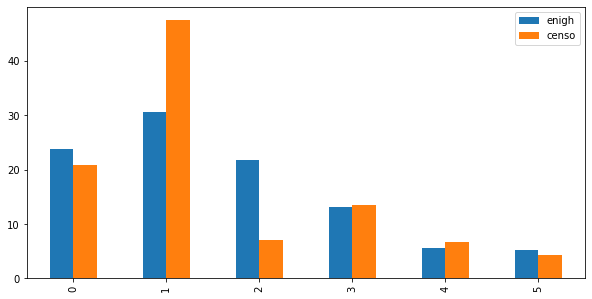

In [ ]:
censo_pred = censo['ing_cor_t_segment'].value_counts(normalize=True)*100
enigh_true = enigh['ing_cor_t_segment'].value_counts(normalize=True)*100
censo_pred = pd.DataFrame(censo_pred)
enigh_true = pd.DataFrame(enigh_true)
censo_pred.columns = ['censo']
enigh_true.columns = ['enigh']
enigh_true.merge(censo_pred,left_index=True,right_index=True).sort_index().plot.bar(figsize=[10,5])

In [ ]:
met = []
for i in range(6):
    met.append((enigh_true.loc[i].values-censo_pred.loc[i].values)/(enigh_true.loc[i].values+censo_pred.loc[i].values))
    print('Segmento ', i,':', met[i])

val=0
for i in range(6):
    val = val + np.abs(met[i])
print('Métrica general:', val/6)

val=0
for i in range(6):
    val = val + np.abs(met[i])*(real_segment_vc.loc[i].values/real_segment_vc.sum().values)
print('Métrica balanceada:', val)

Segmento  0 : [0.06628016]
Segmento  1 : [-0.21619899]
Segmento  2 : [0.50893656]
Segmento  3 : [-0.0170388]
Segmento  4 : [-0.09486418]
Segmento  5 : [0.08866239]
Métrica general: [0.16533018]
Métrica balanceada: [0.20218682]


Graphing the municipalities to buy with google maps. Compare in big cities.

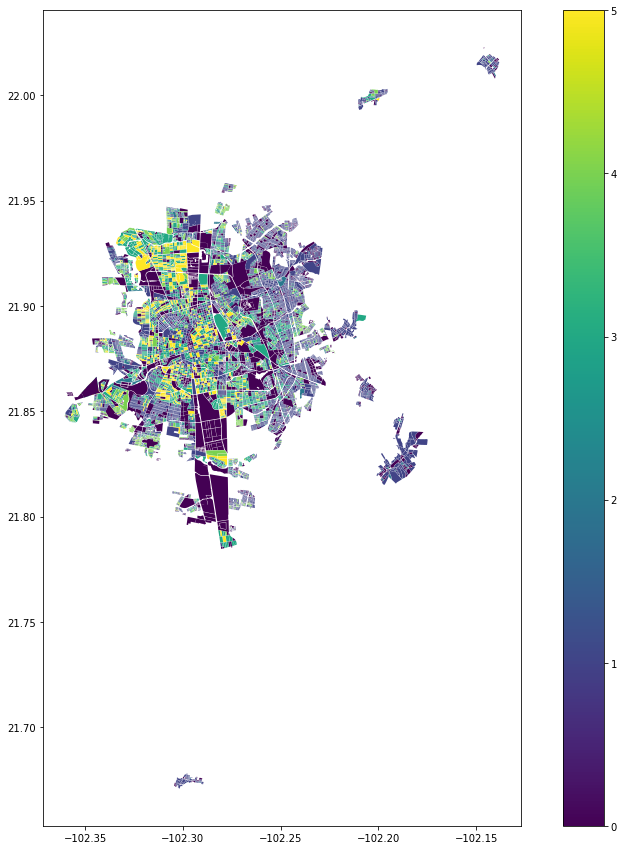

In [ ]:
from matplotlib.collections import PatchCollection

estado_ = '0'+str(estado) if estado<10 else str(estado)
shp = gpd.read_file(f'/content/gdrive/MyDrive/pamgea3_0/shape_estados/{estado_}m.shp')
shp.to_crs('EPSG:4326',inplace=True)

# list of municipalities
muns = ['001']

if len(muns)>0:
    shp = shp[shp['CVE_MUN'].isin(muns)].reset_index(drop=True)
    filename = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/mapas/ing_cor_estado'+str(estado)+'_municipio'+str(muns)+'.png'
else:
    filename = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/mapas/ing_cor_estado'+str(estado)+'.png'
    
shp = shp.merge(censo,left_on='CVEGEO',right_on='CVEGEO')

# shp = shp[shp['ing_cor_t_segment'].isin([2,3,4,5])]
base = shp.plot(column='ing_cor_t_segment',figsize=[15,15],legend=True)

plt.savefig(filename)

**Saving probabilities for each census class**

In [ ]:
a = clf.predict_proba(censo[FEATURES].loc[:, ~censo[FEATURES].columns.duplicated()])

for i in range(6):
    censo['clase_'+str(i)] = a[:, i]

In [ ]:
df2 = censo[['CVEGEO', 'tot_integ', 'ocupados', 'ing_cor_t_segment','clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5']].copy()
df2.shape

(15843, 10)

In [ ]:
df2.head()

,CVEGEO,tot_integ,ocupados,ing_cor_t_segment,clase_0,clase_1,clase_2,clase_3,clase_4,clase_5
0,0100100010017001,3,2,1,0.389044,0.484631,0.074628,0.010722,0.039852,0.001123
1,0100100010017002,4,2,1,0.276237,0.499088,0.157157,0.016230,0.047184,0.004105
2,0100100010017003,4,2,1,0.370457,0.491589,0.083301,0.011322,0.041197,0.002135
3,0100100010017004,4,2,1,0.360951,0.494714,0.092116,0.009374,0.041259,0.001587
4,0100100010017005,3,2,1,0.279308,0.408324,0.179193,0.050803,0.075036,0.007336


In [ ]:
df2.to_csv('/content/gdrive/MyDrive/pamgea3_0/pangea3_2/fase2/proba_ing_cor_'+str(estado)+'.csv', index=False)

Saving the training and test bases, in case you want to study the test metrics for the income and expense variables.

In [ ]:
# Select the training and test data
entrenamiento = enigh.loc[X_train.index].copy()
prueba = enigh.loc[X_test.index].copy()

print(entrenamiento.shape, prueba.shape)

# Calculating the probabilities for the training and test bases
a_train = clf.predict_proba(X_train[FEATURES])
a_test = clf.predict_proba(X_test[FEATURES])

for i in range(6):
    entrenamiento['clase_'+str(i)] = a_train[:, i]
    prueba['clase_'+str(i)] = a_test[:, i]

entrenamiento['ing_cor_t_segment'] = entrenamiento[['clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5']].idxmax(axis="columns").replace({'clase_0':0, 'clase_1':1, 'clase_2':2, 'clase_3':3, 'clase_4':4, 'clase_5':5})
prueba['ing_cor_t_segment'] = prueba[['clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5']].idxmax(axis="columns").replace({'clase_0':0, 'clase_1':1, 'clase_2':2, 'clase_3':3, 'clase_4':4, 'clase_5':5})

print(entrenamiento.shape, prueba.shape)

entrenamiento.to_csv('/content/gdrive/MyDrive/pamgea3_0/pangea3_2/fase2/entrenamiento'+str(estado)+'.csv', index=False)
prueba.to_csv('/content/gdrive/MyDrive/pamgea3_0/pangea3_2/fase2/prueba'+str(estado)+'.csv', index=False)

(1239, 249) (414, 249)
(1239, 255) (414, 255)


### Stage 3:
At this stage the tapestry for the state will be generated.

* Initially it defines the tapestry on the enigh and a grouping is done by its values.
* The tapestry is defined for each block in the census.
* Finally, the value of bock expenditure for the census is obtained.

(This step can be automated for all states)

### 3.1 Tapestry in Enigh Reading the file with the definition of the cuts made in stage 1. In case you don't have the enigh grouping, you must do this step.

In [71]:
# Census data
censo = pd.read_csv('/content/gdrive/MyDrive/pamgea3_0/pangea3_2/fase2/proba_ing_cor_'+str(estado)+'.csv')

In [72]:
# Current income cuts at the state level
nombre = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/breacks/ingreso_estado'+str(estado)+'.json'
breacks = joblib.load(nombre)
breaks_ingreso = breacks['breaks_ingreso']

# Cuts in total number of people and employed persons per household at the national level
breacks = joblib.load('/content/gdrive/MyDrive/pamgea3_0/breaks1/breaks_dic_nacional.json')
breaks_tot_integ = breacks['breaks_tot_integ']
breaks_ocupados = breacks['breaks_ocupados']

In [73]:
breaks_ingreso, breaks_tot_integ, breaks_ocupados

(array([     0.  ,  29144.25,  50001.69,  75652.66, 107041.4 , 146081.62,
        577196.66]), [1.0, 2.0, 4.0, 6.0, 18.0], [0.0, 0.0, 1.0, 2.0, 10.0])

In [74]:

def find_segment(value,intervals_list): 
    n = len(intervals_list)
    segment = np.nan
    for j in range(1,n-1):
        if value<=intervals_list[j]:
            segment = j-1
            break
        elif value<=intervals_list[j+1]:
            segment = j
            break
    if value<intervals_list[0]:
        segment = np.nan
    return segment

breaks2 = [breaks_tot_integ, breaks_ocupados, breaks_ingreso]
variables2 = ['tot_integ', 'ocupados', 'ing_cor']

for i in range(3):
    enigh[variables2[i]+'_segment'] = enigh[variables2[i]].apply(find_segment,args=(breaks2[i],))
    print(variables2[i])
    print((enigh[variables2[i]+'_segment'].value_counts(normalize=True)*100).sort_index())

# Si son nan es por que están por ensima del valor máximo
enigh.loc[enigh['ing_cor_segment'].isnull(), 'ing_cor_segment'] = 5
enigh['ing_cor_segment'] = enigh['ing_cor_segment'].astype(int)

tot_integ
0    30.308530
1    43.375681
2    20.810647
3     5.505142
Name: tot_integ_segment, dtype: float64
ocupados
0    10.828796
1    35.692680
2    32.002420
3    21.476104
Name: ocupados_segment, dtype: float64
ing_cor
0    23.714459
1    30.671506
2    21.839080
3    13.067151
4     5.505142
5     5.202662
Name: ing_cor_segment, dtype: float64


In [75]:
# Creating el tapestry
enigh['tapestry'] = enigh['ing_cor_segment'].astype(str)+'_'+enigh['tot_integ_segment'].astype(str)+'_'+enigh['ocupados_segment'].astype(str)

Deciding if we delete some groups

In [76]:
print(enigh.loc[enigh['tapestry'].str[0] == '4', 'tapestry'].shape)
enigh.loc[enigh['tapestry'].str[0] == '4', 'tapestry'].value_counts()

(91,)


4_1_2    18
4_1_3    16
4_2_3    12
4_1_1     8
4_2_2     8
4_0_2     8
4_3_3     6
4_0_1     4
4_1_0     3
4_0_0     3
4_3_2     2
4_2_1     2
4_3_1     1
Name: tapestry, dtype: int64

In [77]:
print(enigh.loc[enigh['tapestry'].str[0] == '5', 'tapestry'].shape)
enigh.loc[enigh['tapestry'].str[0] == '5', 'tapestry'].value_counts()

(86,)


5_1_3    22
5_1_2    17
5_2_3    16
5_1_1    10
5_3_3     6
5_0_1     5
5_0_2     5
5_2_2     2
5_1_0     1
5_3_2     1
5_2_1     1
Name: tapestry, dtype: int64

**Passing the elements of the last two classes to `4_*_*` and `5_*_*`**

**Note:** The graph is very different from the previous one, since the last two groups, even when they were united, had almost no segments

In [78]:
enigh.loc[enigh['tapestry'].str[0] == '4', 'tapestry'] = '4_*_*'
enigh.loc[enigh['tapestry'].str[0] == '5', 'tapestry'] = '5_*_*'

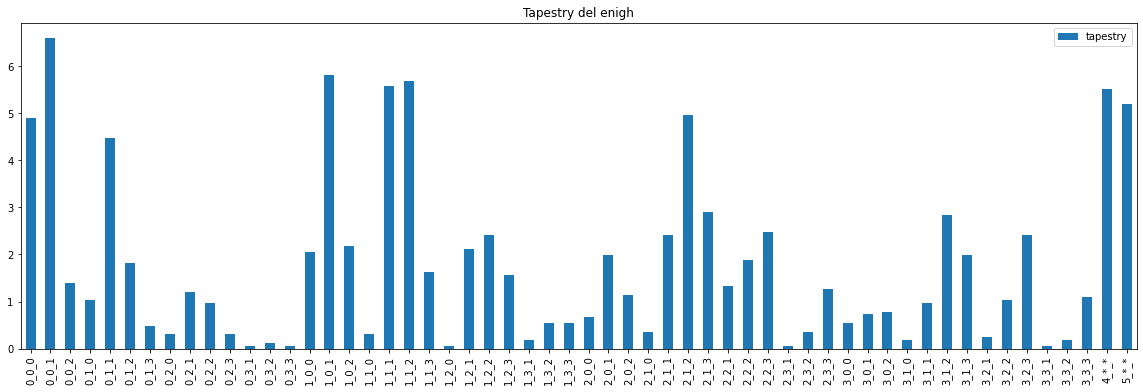

In [79]:
# Compare tapestry
real_segment_vc = enigh['tapestry'].value_counts(normalize=True)*100

real_segment_vc = pd.DataFrame(real_segment_vc).sort_index()

real_segment_vc.sort_index().plot.bar(figsize=[20, 6])
plt.title('Tapestry del enigh')
plt.show()

### 3.2.1 Distribution of the number of people per household

Instead of putting 100% in that the total number of members is in the mean:
* The state (or municipal) distribution of the variable is obtained, from the enigh
* For each block, the distribution obtained from enihg is created, with the average in the corresponding census value, and the probability that households are in each of the segments is calculated.
* These probabilities are multiplied with the other probabilities of the tapestry, so as to obtain the probability that the typical household of each block belongs to each of the variables.

(array([402., 402., 402., 501., 600., 600., 600., 700., 700., 700., 717.,
        734., 734., 734., 458., 458., 229., 458., 230., 230., 230., 148.,
         66.,  66.,  66.,  58.,  58.,  58.,  43.,  28.,  28.,  28.,   8.,
         16.,  16.,  16.,  10.,  10.,  10.,   5.,   0.,   0.,   0.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.]),
 array([ 1.   ,  1.277,  1.554,  1.831,  2.108,  2.385,  2.662,  2.939,
         3.216,  3.493,  3.77 ,  4.047,  4.324,  4.601,  4.878,  5.155,
         5.432,  5.709,  5.986,  6.263,  6.54 ,  6.817,  7.094,  7.371,
         7.648,  7.925,  8.202,  8.479,  8.756,  9.033,  9.31 ,  9.587,
         9.864, 10.141, 10.418, 10.695, 10.972, 11.249, 11.526, 11.803,
        12.08 , 12.357, 12.634, 12.911, 13.188, 13.465, 13.742, 14.019,
        14.296, 14.573, 14.85 ]),
 <a list of 50 Patch objects>)

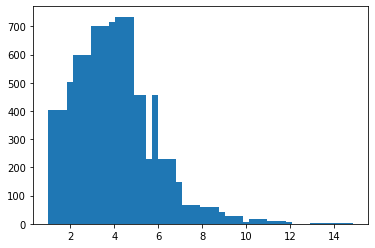

In [80]:
val = enigh['tot_integ'].value_counts()

ing = enigh['tot_integ'].tolist()

for i in range(len(val.index)):
    ing= ing + list(np.repeat(np.linspace(val.index[i]+0.15, val.index[i]+0.85, 6), val.values[i]))
    
plt.hist(ing, bins=50)

In [81]:
from scipy import stats
from fitter import Fitter

start = time.time()

f = Fitter(ing)#enigh['tot_integ'].values)
f.fit()

end = time.time()
print('Running time: {:.2f} minutes'.format((end-start)/60))

f.summary()

KeyboardInterrupt: ignored

In [ ]:
# best approximation
#f.get_best(method='sumsquare_error')
f.fitted_param['mielke']

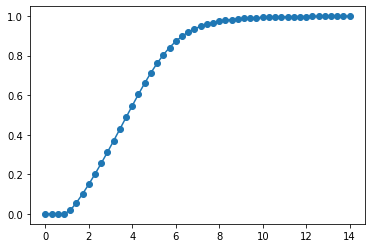

In [86]:
from pylab import linspace, plot
import scipy.stats

dist = scipy.stats.mielke
param = (1.2141543114975002, 5.649409918554957, 0.9684464558884465, 4.929259920874483)
X = linspace(0,14, 50)
pdf_fitted = dist.cdf(X, *param)
plot(X, pdf_fitted, 'o-')

Calculating the probability of the number of people per household in each block

In [87]:
breaks2 = [breaks_tot_integ, breaks_ocupados]
variables2 = ['tot_integ', 'ocupados']

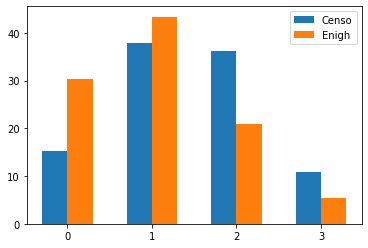

In [88]:
# how much is added to the average

anteriores = ['tot_integ_clase0', 'tot_integ_clase1', 'tot_integ_clase2']

for i in list(censo['tot_integ'].value_counts().index):
    mean = i - 0.9684464558884465 - 1 #1.7
    for j in range(4):
        if j==0:
            val = dist.cdf(breaks_tot_integ[j+1], k=1.2141543114975002, s=5.649409918554957, loc=mean, scale= 4.929259920874483)
            censo.loc[censo['tot_integ']==i, 'tot_integ_clase'+str(j)] = val
        elif j==3:
            val = 1 - dist.cdf(breaks_tot_integ[j], k=1.2141543114975002, s=5.649409918554957, loc=mean, scale= 4.929259920874483)
            censo.loc[censo['tot_integ']==i, 'tot_integ_clase'+str(j)] = val #[x if x >0 else 0 for x in val]
        else:
            val = dist.cdf(breaks_tot_integ[j+1], k=1.2141543114975002, s=5.649409918554957, loc=mean, scale= 4.929259920874483) - dist.cdf(breaks_tot_integ[j], k=1.2141543114975002, s=5.649409918554957, loc=mean, scale= 4.929259920874483)
            censo.loc[censo['tot_integ']==i, 'tot_integ_clase'+str(j)] = val

censo['tot_integ_clase'] = censo[['tot_integ_clase0', 'tot_integ_clase1', 'tot_integ_clase2', 'tot_integ_clase3']].idxmax(axis="columns").replace({'tot_integ_clase0':0, 'tot_integ_clase1':1, 'tot_integ_clase2':2, 'tot_integ_clase3':3})

censo['tot_integ_clase'] = censo[['tot_integ_clase0', 'tot_integ_clase1', 'tot_integ_clase2', 'tot_integ_clase3']].idxmax(axis="columns").replace({'tot_integ_clase0':0, 'tot_integ_clase1':1, 'tot_integ_clase2':2, 'tot_integ_clase3':3})

# Graphic
x = np.array(list(range(4)))
p = (censo['tot_integ_clase'].value_counts(normalize=True)*100).sort_index().values
e = (enigh['tot_integ_segment'].value_counts(normalize=True)*100).sort_index().values
  
plt.bar(x - 0.15, p, 0.3, label = 'Censo')
plt.bar(x + 0.15, e, 0.3, label = 'Enigh')
plt.xticks(x, x)
plt.legend()
plt.show()


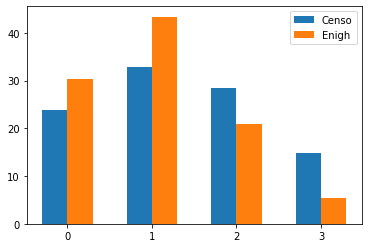

In [89]:
# Getting a random number that follows the distribution
for i in list(censo['tot_integ'].value_counts().index):
  mean = i - 0.9684464558884465 - 1 #1.7
  censo.loc[censo['tot_integ']==i, 'tot_integ_sim'] = dist.rvs(k=1.2141543114975002, s=5.649409918554957, loc=mean, scale= 4.929259920874483, size=sum(censo['tot_integ']==i), random_state=1234)

# Adjusting to be integers greater than zero
censo['tot_integ_sim'] = round(censo['tot_integ_sim'], 0).astype(int)
censo['tot_integ_sim'] = np.where(censo['tot_integ_sim']<0, 1, censo['tot_integ_sim'])

# Getting the ranking
censo['tot_integ_segment_sim'] = censo['tot_integ_sim'].apply(find_segment,args=(breaks_tot_integ,))

censo['tot_integ_segment_sim'] = np.where(censo['tot_integ_sim']==0, 0, censo['tot_integ_segment_sim'])
censo['tot_integ_segment_sim'] = np.where(censo['tot_integ_sim']>=breaks_tot_integ[-1], 3, censo['tot_integ_segment_sim'])

# Observing the results
x = np.array(list(range(4)))
p = (censo['tot_integ_segment_sim'].value_counts(normalize=True)*100).sort_index().values
e = (enigh['tot_integ_segment'].value_counts(normalize=True)*100).sort_index().values
  
plt.bar(x - 0.15, p, 0.3, label = 'Censo')
plt.bar(x + 0.15, e, 0.3, label = 'Enigh')
plt.xticks(x, x)
plt.legend()
plt.show()

### 3.2.1 Distribution for the number of people and employed per household


(array([358., 179., 179., 179., 179., 590., 590., 590., 590., 590., 590.,
        529., 529., 529., 529., 529., 758., 229., 229., 229., 229., 229.,
         86.,  86.,  86.,  86.,  86.,  86.,  31.,  31.,  31.,  31.,  31.,
         38.,   7.,   7.,   7.,   7.,   7.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.]),
 array([0.   , 0.177, 0.354, 0.531, 0.708, 0.885, 1.062, 1.239, 1.416,
        1.593, 1.77 , 1.947, 2.124, 2.301, 2.478, 2.655, 2.832, 3.009,
        3.186, 3.363, 3.54 , 3.717, 3.894, 4.071, 4.248, 4.425, 4.602,
        4.779, 4.956, 5.133, 5.31 , 5.487, 5.664, 5.841, 6.018, 6.195,
        6.372, 6.549, 6.726, 6.903, 7.08 , 7.257, 7.434, 7.611, 7.788,
        7.965, 8.142, 8.319, 8.496, 8.673, 8.85 ]),
 <a list of 50 Patch objects>)

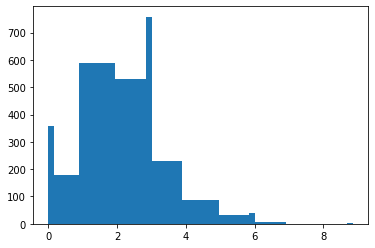

In [85]:
val = enigh['ocupados'].value_counts()

ocu = enigh['ocupados'].tolist()

for i in range(len(val.index)):
    ocu= ocu + list(np.repeat(np.linspace(val.index[i]+0.15, val.index[i]+0.85, 5), val.values[i]))
    
plt.hist(ocu, bins=50)

Running time: 6.17 minutes


,sumsquare_error,aic,bic,kl_div
dgamma,2.785396,816.413257,-81078.987109,inf
skewnorm,2.789066,798.996130,-81065.925129,inf
norminvgauss,2.791424,749.999270,-81048.344136,inf
weibull_max,2.791511,751.572893,-81057.237344,inf
frechet_l,2.791511,751.572893,-81057.237344,inf


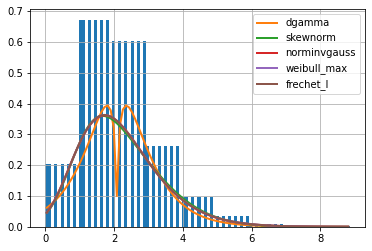

In [ ]:
from scipy import stats
from fitter import Fitter

start = time.time()

f = Fitter(ocu)#enigh['tot_integ'].values)
f.fit()

end = time.time()
print('Running time: {:.2f} minutes'.format((end-start)/60))

f.summary()

In [ ]:
# La mejor aproximación
#f.get_best(method='sumsquare_error')
f.fitted_param['skewnorm']

(26.824299992539252,
 23.992845348887712,
 -1.5425667309807132,
 1.8513015987337678)

In [ ]:
#b = f.get_best(method='sumsquare_error').values()
#list(list(b)[0].values())

[5.10782986052344, 0.2359289624135974, 0.8106384808928204]

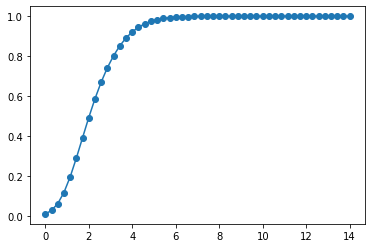

In [90]:
from pylab import linspace, plot
import scipy.stats

dist = scipy.stats.skewnorm
param = (2.9191685095369353, 0.8006910433468928, 1.815458588743899)
X = linspace(0,14, 50)
pdf_fitted = dist.cdf(X, *param)
plot(X, pdf_fitted, 'o-')

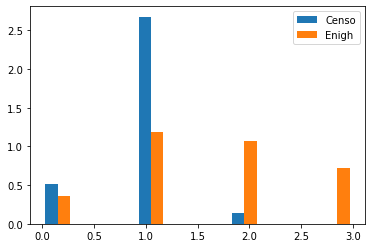

In [91]:
# Set how much to add to the mean

anteriores = ['ocupados_clase0', 'ocupados_clase1', 'ocupados_clase2']

for i in list(censo['ocupados'].value_counts().index):
    mean = i - 0.8006910433468928 - 0.5

    for j in range(4):
        if j==0:
            val = dist.cdf(breaks_tot_integ[j+1], a=5.10782986052344, loc=mean, scale=1.815458588743899)
            censo.loc[censo['ocupados']==i, 'ocupados_clase'+str(j)] = val
        elif j==3:
            val = 1 - dist.cdf(breaks_tot_integ[j], a=5.10782986052344, loc=mean, scale=1.815458588743899)
            censo.loc[censo['ocupados']==i, 'ocupados_clase'+str(j)] = val #[x if x >0 else 0 for x in val]
        else:
            val = dist.cdf(breaks_tot_integ[j+1], a=5.10782986052344, loc=mean, scale=1.815458588743899) - dist.cdf(breaks_ocupados[j], a=5.10782986052344, loc=mean, scale=1.815458588743899)
            censo.loc[censo['ocupados']==i, 'ocupados_clase'+str(j)] = val

censo['ocupados_clase'] = censo[['ocupados_clase0', 'ocupados_clase1', 'ocupados_clase2', 'ocupados_clase3']].idxmax(axis="columns").replace({'ocupados_clase0':0, 'ocupados_clase1':1, 'ocupados_clase2':2, 'ocupados_clase3':3})

plt.hist([censo['ocupados_clase'], enigh['ocupados_segment']], label=['Censo', 'Enigh'], density=True)
plt.legend(loc='upper right')
plt.show()

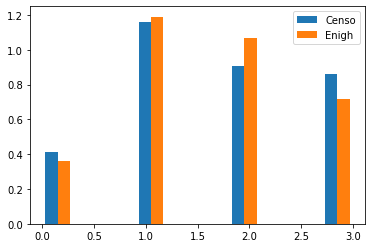

In [92]:
# Getting a random number that follows the distribution
for i in list(censo['ocupados'].value_counts().index):
  mean = i - 0.8006910433468928 - 0.5
  censo.loc[censo['ocupados']==i, 'ocupados_sim'] = dist.rvs(a=5.10782986052344, loc=mean, scale=1.815458588743899, size=sum(censo['ocupados']==i), random_state=1234)

# Adjusting to be integers greater than zero
censo['ocupados_sim'] = round(censo['ocupados_sim'], 0).astype(int)
censo['ocupados_sim'] = np.where(censo['ocupados_sim']<0, 1, censo['ocupados_sim'])

# Getting the classification
censo['ocupados_segment_sim'] = censo['ocupados_sim'].apply(find_segment,args=(breaks_ocupados,))

censo['ocupados_segment_sim'] = np.where(censo['ocupados_sim']==0, 0, censo['ocupados_segment_sim'])
censo['ocupados_segment_sim'] = np.where(censo['ocupados_sim']>=breaks_ocupados[-1], 3, censo['ocupados_segment_sim'])

# Getting the classification
plt.hist([censo['ocupados_segment_sim'], enigh['ocupados_segment']], label=['Censo', 'Enigh'], density=True)
plt.legend(loc='upper right')
plt.show()  

### 3.2.2 Tapestry for synthetic probability of home and employed

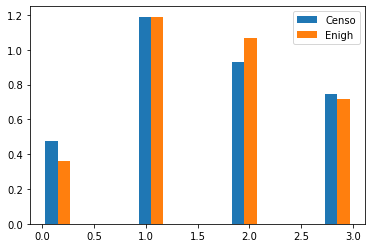

In [93]:
# Delimiting the number of people employed by the number of people in the home
censo['ocupados_sim'] = np.where(censo['ocupados_sim'] > censo['tot_integ_sim'] , censo['tot_integ_sim'], censo['ocupados_sim']).astype(int)

# Segmenting the busy variable
censo['ocupados_segment_sim'] = censo['ocupados_sim'].apply(find_segment,args=(breaks_ocupados,))

# Observing the results
plt.hist([censo['ocupados_segment_sim'], enigh['ocupados_segment']], label=['Censo', 'Enigh'], density=True)
plt.legend(loc='upper right')
plt.show()  

In [94]:
# If there is a null value, then they belong to the last segment
censo.loc[censo['ocupados_segment_sim'].isnull(), 'ocupados_segment_sim'] = 3
censo['ocupados_segment_sim'] = censo['ocupados_segment_sim'].astype(int)

In [95]:
# Creating tapestry
censo['ing_cor_t_segment'] = censo['ing_cor_t_segment'].astype(int)
censo['tapestry'] = censo['ing_cor_t_segment'].astype(str)+'_'+censo['tot_integ_segment_sim'].astype(int).astype(str)+'_'+censo['ocupados_segment_sim'].astype(str)
print(censo['tapestry'].unique().shape, censo.shape)

censo.loc[censo['tapestry'].str[0] == '4', 'tapestry'] = '4_*_*'
censo.loc[censo['tapestry'].str[0] == '5', 'tapestry'] = '5_*_*'
print(censo['tapestry'].unique().shape)

(90,) (15843, 25)
(62,)


In [96]:
# Creating a list of all possible segments (excluding _*_*)

from itertools import product

x = [str(i)+'_' for i in range(4)]
y = [str(i)+'_' for i in range(4)]
lista1 = [i+j for i, j in product(x, y)]

z = [str(i) for i in range(4)]
lista = [i+j for i, j in product(lista1, z)]

#lista
censo_tapestry = pd.DataFrame(columns=['CVEGEO']+lista+['4_*_*', '5_*_*'])
censo_tapestry['CVEGEO'] = censo['CVEGEO'].copy()
censo_tapestry['tapestry'] = censo['tapestry'].copy()
censo_tapestry['est'] = censo['CVEGEO'].str[:2].copy()
censo_tapestry['mun'] = censo['CVEGEO'].str[2:5].copy()

censo_tapestry.shape

(15843, 70)

In [97]:
censo['tot_integ_segment_sim'] = censo['tot_integ_segment_sim'].astype(int)

In [98]:
clases = ['clase_0',	'clase_1',	'clase_2',	'clase_3',	'clase_4',	'clase_5']

# Creating tapestry
for i in range(4): # number of participants
  for j in range(4): # busy
    for k in range(6): # income segment
      cond = (censo['tot_integ_segment_sim'] == i) & (censo['ocupados_segment_sim'] == j) #& (prueba['ing_cor_t_segment'] == k)
      if k<=3:
        col = str(k)+'_'+str(i)+'_'+str(j)
        censo_tapestry.loc[cond, col] = censo.loc[cond, 'clase_'+str(k)].copy()
      else:
        censo_tapestry.loc[cond, str(k)+'_*_*'] = censo.loc[cond, 'clase_'+str(k)].copy()
      print(col)

# Null values are set equal to zero
censo_tapestry = censo_tapestry.fillna(0)

# Eliminating inconsistent cases between members and employees
for i in range(4):
    censo_tapestry[str(i)+'_0_2'] = censo_tapestry[str(i)+'_0_2'] + censo_tapestry[str(i)+'_0_3'].fillna(0)
    censo_tapestry = censo_tapestry.drop(columns=[str(i)+'_0_3'])

0_0_0
1_0_0
2_0_0
3_0_0
3_0_0
3_0_0
0_0_1
1_0_1
2_0_1
3_0_1
3_0_1
3_0_1
0_0_2
1_0_2
2_0_2
3_0_2
3_0_2
3_0_2
0_0_3
1_0_3
2_0_3
3_0_3
3_0_3
3_0_3
0_1_0
1_1_0
2_1_0
3_1_0
3_1_0
3_1_0
0_1_1
1_1_1
2_1_1
3_1_1
3_1_1
3_1_1
0_1_2
1_1_2
2_1_2
3_1_2
3_1_2
3_1_2
0_1_3
1_1_3
2_1_3
3_1_3
3_1_3
3_1_3
0_2_0
1_2_0
2_2_0
3_2_0
3_2_0
3_2_0
0_2_1
1_2_1
2_2_1
3_2_1
3_2_1
3_2_1
0_2_2
1_2_2
2_2_2
3_2_2
3_2_2
3_2_2
0_2_3
1_2_3
2_2_3
3_2_3
3_2_3
3_2_3
0_3_0
1_3_0
2_3_0
3_3_0
3_3_0
3_3_0
0_3_1
1_3_1
2_3_1
3_3_1
3_3_1
3_3_1
0_3_2
1_3_2
2_3_2
3_3_2
3_3_2
3_3_2
0_3_3
1_3_3
2_3_3
3_3_3
3_3_3
3_3_3


In [99]:
# Checking that the probability of the tapestry is one
a = censo_tapestry.drop(columns=['CVEGEO', 'tapestry', 'est', 'mun']).sum(axis=1)
sum((a<1.0001) & (a>0.9999)), len(a)

(15843, 15843)

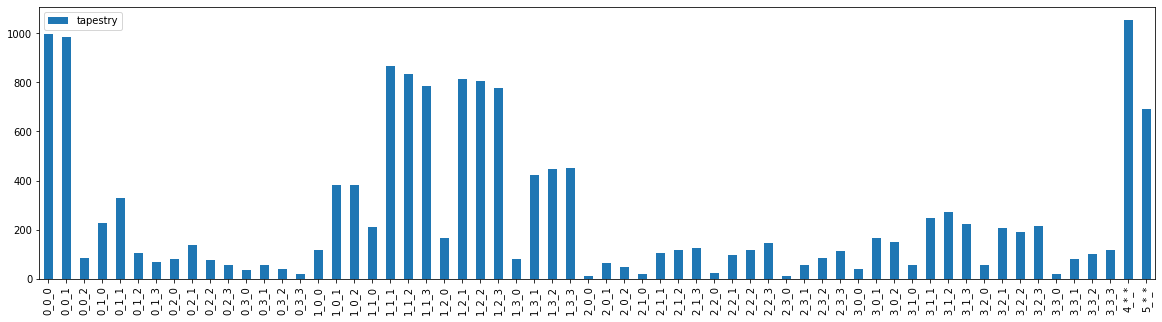

In [100]:
# Graphing the results
acumulado = censo['tapestry'].value_counts()

enigh_ac = pd.DataFrame(acumulado)

enigh_ac.sort_index().plot.bar(figsize=[20,5])

### 3.3 Fixing the enigh variables, so that all segments of the enigh tapestry are had in the censo

In [101]:
# Studying if there is any segment of the tapestry without probabilities
col_no_vacias_entrenamiento = list(enigh['tapestry'].unique())
print('Número de elementos distintos del tapestry en entrenamiento:', len(col_no_vacias_entrenamiento))  

col_no_vacias_censo = []
for i in censo_tapestry.drop(columns=['CVEGEO', 'tapestry', 'est', 'mun']).columns:
    if censo_tapestry[i].sum() != 0:
        col_no_vacias_censo.append(i)
        
print('Número de elementos distintos del tapestry en el censo:', len(col_no_vacias_censo))  

# empty columns
print('Columnas vacias en el censo, :', list(set(censo_tapestry.drop(columns=['CVEGEO', 'tapestry', 'est', 'mun']).columns.to_list()) - set(col_no_vacias_censo)))

Número de elementos distintos del tapestry en entrenamiento: 56
Número de elementos distintos del tapestry en el censo: 62
Columnas vacias en el censo, : []


In [102]:
from correct3 import adjustdf, find_next_ing

# Studying the cases that are in the census tapestry and not in the ENIGH tapestry
faltantes = list(set(col_no_vacias_censo)-set(col_no_vacias_entrenamiento))
faltantes

['2_3_0', '3_2_0', '0_3_0', '2_2_0', '1_3_0', '3_3_0']

In [103]:
# use if function has error
enigh['ing_cor_t_segment'] = enigh['ing_cor_segment'].copy()

In [104]:
# Correcting the enigh base so that it has all sectors
eni, censo_p = adjustdf(enigh, censo_tapestry.copy(), faltantes)
eni.shape, censo_p.shape

1653
1_3_0 3_3_0 original: 2_3_0
######
Empty DataFrame
Columns: [folioviv, foliohog, municipio, tam_loc, est_socio, est_dis, upm, factor, clase_hog, sexo_jefe, edad_jefe, educa_jefe, tot_integ, hombres, mujeres, mayores, menores, p12_64, p65mas, ocupados, percep_ing, perc_ocupa, ing_cor, ingtrab, trabajo, sueldos, horas_extr, comisiones, aguinaldo, indemtrab, otra_rem, remu_espec, negocio, noagrop, industria, comercio, servicios, agrope, agricolas, pecuarios, reproducc, pesca, otros_trab, rentas, utilidad, arrenda, transfer, jubilacion, becas, donativos, remesas, bene_gob, transf_hog, trans_inst, estim_alqu, otros_ing, gasto_mon, alimentos, ali_dentro, cereales, carnes, pescado, leche, huevo, aceites, tuberculo, verduras, frutas, azucar, cafe, especias, otros_alim, bebidas, ali_fuera, tabaco, vesti_calz, vestido, calzado, vivienda, alquiler, pred_cons, agua, energia, limpieza, cuidados, utensilios, enseres, salud, atenc_ambu, hospital, medicinas, transporte, publico, foraneo, adqui_ve

((1659, 253), (15843, 66))

In [105]:
# Checking that they have the same elements of the tapestry
list(set(eni['tapestry'].unique())-set(censo_p.drop(columns=['CVEGEO', 'tapestry', 'est', 'mun']).columns))

[]

### 3.4 Obtaining the income and expense values

Expenditure and income columns from which we will obtain values

In [106]:
var = ['ing_cor', 'ingtrab',
       'trabajo', 'sueldos', 'horas_extr', 'comisiones', 'aguinaldo',
       'indemtrab', 'otra_rem', 'remu_espec', 'negocio', 'noagrop',
       'industria', 'comercio', 'servicios', 'agrope', 'agricolas',
       'pecuarios', 'reproducc', 'pesca', 'otros_trab', 'rentas', 'utilidad',
       'arrenda', 'transfer', 'jubilacion', 'becas', 'donativos',
       'remesas', 'bene_gob', 'transf_hog', 'trans_inst', 'estim_alqu',
       'otros_ing', 'gasto_mon', 'alimentos', 'ali_dentro', 'cereales',
       'carnes', 'pescado', 'leche', 'huevo', 'aceites', 'tuberculo',
       'verduras', 'frutas', 'azucar', 'cafe', 'especias', 'otros_alim',
       'bebidas', 'ali_fuera', 'tabaco', 'vesti_calz', 'vestido', 'calzado',
       'vivienda', 'alquiler', 'pred_cons', 'agua', 'energia', 'limpieza',
       'cuidados', 'utensilios', 'enseres', 'salud', 'atenc_ambu', 'hospital',
       'medicinas', 'transporte', 'publico', 'foraneo', 'adqui_vehi',
       'mantenim', 'refaccion', 'combus', 'comunica', 'educa_espa',
       'educacion', 'esparci', 'paq_turist', 'personales', 'cuida_pers',
       'acces_pers', 'otros_gas', 'transf_gas', 'percep_tot', 'retiro_inv',
       'prestamos', 'otras_perc', 'ero_nm_viv', 'ero_nm_hog', 'erogac_tot',
       'cuota_viv', 'mater_serv', 'material', 'servicio', 'deposito',
       'prest_terc', 'pago_tarje', 'deudas', 'balance', 'otras_erog', 'smg']

tapestry = list(eni['tapestry'].unique())

In [107]:
eni[eni[var].sum(axis=1)==0]

,folioviv,foliohog,municipio,tam_loc,est_socio,est_dis,upm,factor,clase_hog,sexo_jefe,...,indice_ingreso,valor_idh,vehiculo,ing_cor_t,ing_cor_t_segment,tot_integ_segment,ocupados_segment,ing_cor_segment,tapestry,0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2_3_0,0.0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0_3_0,0.0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1_3_0,0.0


In [110]:
eni.loc[eni['tapestry']=='1_3_0', var] = eni.loc[(eni['tapestry']=='1_2_0') | (eni['tapestry']=='1_3_1'), var].mean().values

eni.loc[eni['tapestry']=='2_3_0', var] = eni.loc[(eni['tapestry']=='2_2_0') | (eni['tapestry']=='2_3_1'), var].mean().values

eni.loc[eni['tapestry']=='0_3_0', var] = eni.loc[(eni['tapestry']=='0_2_0') | (eni['tapestry']=='0_3_1'), var].mean().values

eni[eni[var].sum(axis=1)==0].shape

(0, 253)

Data frame with the quantiles for each income segment by tapestry and variable

In [111]:
# Creating the dataframe with the slices we will use
var_ext =  [ i+str(j) for i in var for j in tapestry]
df = pd.DataFrame(np.zeros((7, len(var_ext))), columns=var_ext)

cuantiles = np.linspace(0,1, 7)

for i in var:
  for j in tapestry:
    # Saving the quartiles for each of the variables
    df.loc[:, i+str(j)] = list(np.quantile(eni.loc[eni['tapestry']==j, i], cuantiles))

Pasting the data from both bases

In [112]:
# With merge we get errors, so we sort the bases and then merge them
(censo_p[['CVEGEO']].sort_values(by=['CVEGEO']) == censo[['CVEGEO']].sort_values(by=['CVEGEO'])).sum(), censo.shape[0]

(CVEGEO    15843
 dtype: int64, 15843)

In [113]:
censo_p = censo_p.sort_values(by=['CVEGEO']).reset_index(drop=True)
censo = censo.sort_values(by=['CVEGEO']).reset_index(drop=True)

censo_p[['clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5', 'ing_cor_t_segment']] = censo[['clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5', 'ing_cor_t_segment']].copy()
censo_p.shape

(15843, 73)

Creating the spend base

In [114]:
start = time.time()

df3 = pd.DataFrame(np.zeros((censo_p.shape[0], len(var))), columns=var)
df3['CVEGEO'] = censo_p['CVEGEO'].copy().values
df3['tapestry'] = censo_p['tapestry'].copy().values
df3['ing_cor_t_segment'] = censo_p['ing_cor_t_segment'].copy().values

for i in tapestry:
# Select the predominant class 
# Segmenting by the income cutoff
  temp = censo_p[censo_p['tapestry'] == i].copy()
  for j in range(6):
    # Iterating over the possible classes
    for k in var:
        df3.loc[df3['tapestry'] == i, k] = df3.loc[df3['tapestry'] == i, k].copy().values + np.random.uniform(df.loc[j, k+i], df.loc[j+1, k+i], temp.shape[0])*temp['clase_'+str(j)].copy().values
  print(i)

end = time.time()
print('Running time: {:.2f} minutes'.format((end-start)/60))

0_1_1
1_1_1
1_0_2
2_0_1
3_0_1
2_1_1
0_0_0
0_0_1
5_*_*
2_2_1
0_0_2
1_1_0
3_2_2
1_2_3
1_0_0
0_2_2
0_1_3
0_2_1
1_1_2
2_1_3
0_1_0
0_1_2
1_2_1
3_2_1
3_2_3
1_0_1
3_0_2
2_3_3
2_1_2
1_3_2
3_1_2
2_2_2
4_*_*
3_0_0
2_2_3
1_2_2
2_0_2
3_1_3
2_0_0
3_3_3
1_1_3
2_1_0
1_3_1
1_3_3
3_1_1
1_2_0
3_1_0
0_2_0
0_3_2
0_3_3
2_3_2
0_2_3
3_3_2
0_3_1
3_3_1
2_3_1
2_3_0
3_2_0
0_3_0
2_2_0
1_3_0
3_3_0
Running time: 2.73 minutes


In [115]:
df

,ing_cor0_1_1,ing_cor1_1_1,ing_cor1_0_2,ing_cor2_0_1,ing_cor3_0_1,ing_cor2_1_1,ing_cor0_0_0,ing_cor0_0_1,ing_cor5_*_*,ing_cor2_2_1,...,smg3_3_2,smg0_3_1,smg3_3_1,smg2_3_1,smg2_3_0,smg3_2_0,smg0_3_0,smg2_2_0,smg1_3_0,smg3_3_0
0,4220.490000,29464.510000,29282.470000,50411.170000,77995.240000,50581.750,4212.530000,1803.73,147165.110000,50605.450,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
1,14955.788333,31982.158333,33782.088333,52487.530000,88616.210000,52530.045,11102.466667,11509.31,156374.938333,52942.085,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
2,18161.706667,34540.460000,36814.716667,55471.583333,90399.410000,55081.220,15945.673333,17191.18,169191.596667,55144.350,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
3,20923.315000,37767.080000,38801.590000,58996.020000,94139.805000,57862.600,18743.810000,20168.03,183113.565000,61040.305,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
4,23923.596667,40547.706667,41007.893333,62216.960000,97048.006667,61934.150,21328.463333,23879.00,201560.140000,63073.740,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
5,26771.115000,43934.625000,44498.543333,67958.416667,102194.353333,66012.855,24154.576667,26764.26,249227.820000,64987.570,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8
6,29144.250000,49054.860000,48068.010000,74936.250000,104058.560000,74256.930,28830.010000,29015.86,477196.660000,69228.650,...,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8,11089.8


In [116]:
df3

,ing_cor,ingtrab,trabajo,sueldos,horas_extr,comisiones,aguinaldo,indemtrab,otra_rem,remu_espec,...,deposito,prest_terc,pago_tarje,deudas,balance,otras_erog,smg,CVEGEO,tapestry,ing_cor_t_segment
0,33422.246743,11772.247931,10829.209473,7141.511393,12.838418,12.356432,108.759228,0.000000,4.053972,23.886382,...,103.113773,0.000000,2.750512,4.258599,4.543083,3.245904,11089.8,0100100010017001,1_0_1,1
1,38656.341927,27292.306777,22156.120987,22079.607933,0.738361,7.864980,183.414322,1.978679,57.257963,83.761392,...,195.313310,0.000000,0.000000,1.476796,0.000000,27.937301,11089.8,0100100010017002,1_1_3,1
2,38493.116509,22019.802154,23984.765945,19828.995362,0.923181,4.412279,89.901262,9.428201,2.982887,7.344705,...,330.526859,1.146301,0.121834,3.761719,0.084137,1.625507,11089.8,0100100010017003,1_2_3,1
3,31920.827429,18684.942901,15530.440425,11590.293055,4.306768,18.877734,407.065325,0.208316,2.110787,12.150544,...,50.090502,0.000000,0.148014,2.922263,0.000000,4.860411,11089.8,0100100010017004,1_2_1,1
4,36303.415428,27091.073819,22511.243870,14754.046265,26.155264,175.606791,307.787371,24.935094,18.992351,105.577436,...,477.513267,17.214991,64.515419,32.064311,4.989070,54.757963,11089.8,0100100010017005,1_1_2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15838,11345.334994,1977.336389,728.737350,676.459989,0.000000,0.000000,22.616123,0.000000,7.188433,35.732588,...,991.246039,1.381006,0.000000,24.939529,253.179909,0.000000,11089.8,010110138023A040,0_0_2,0
15839,10511.847091,21.401339,10.343439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.526280,...,8.516505,0.000000,0.000000,0.000000,0.000000,0.000000,11089.8,010110138023A041,0_1_0,0
15840,15053.384368,9503.459397,5269.859373,4936.077946,0.000000,9.482601,19.207400,0.000000,0.000000,0.000000,...,18.169798,0.000000,125.464317,0.000000,1102.967576,0.000000,11089.8,010110138023A042,0_2_3,0
15841,35140.108928,23118.638121,9020.535300,8332.716662,13.598824,0.698532,38.240635,0.828722,42.380476,172.510706,...,190.450745,24.771588,49.974062,0.000000,72.007779,37.767018,11089.8,010110138023A043,1_3_3,1


In [117]:
# guarde el de la media y la mediana
filename = '/content/gdrive/MyDrive/pamgea3_0/pangea3_2/ingasto/estado'+str(estado)+'.csv' # Siguiendo '3.2.2 Tapestry procedimiento original'
df3.to_csv(filename, index=False)

### Graphing the results

In [118]:
estado=1
censo2 = pd.read_csv('/content/gdrive/MyDrive/pamgea3_0/pangea3_2/ingasto/estado'+str(estado)+'.csv')

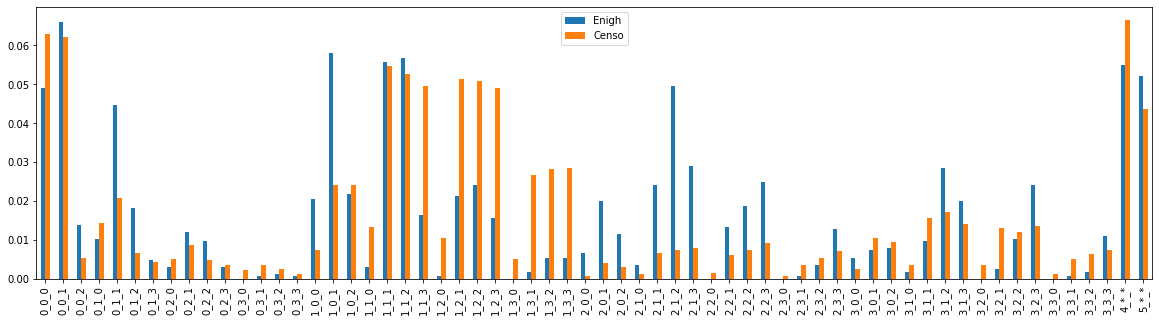

In [119]:
acumulado = censo2['tapestry'].value_counts(normalize=True)
acumulado2 = enigh['tapestry'].value_counts(normalize=True)

censo_ac = pd.DataFrame(acumulado)
enigh_ac = pd.DataFrame(acumulado2)
censo_ac.columns = ['Censo']
enigh_ac.columns = ['Enigh']
enigh_ac.merge(censo_ac, left_index=True, right_index=True, how='outer').sort_index().plot.bar(figsize=[20,5])

### Comparing Income and Expenditure

In [120]:
from numpy.core.fromnumeric import mean

# ENIGH variables
enigh['ing_gasto'] = enigh['ing_cor'] - enigh['gasto_mon']
enigh['ing_gasto'] = np.where(enigh['ing_gasto'] < 0, 1, 0)
print('Cases where spending is greater than income', enigh['ing_gasto'].sum())
print('Percentage of data with more expenses than income', enigh['ing_gasto'].sum()/enigh.shape[0])
print('How much more is the expense than the average income in those cases?', (enigh.loc[enigh['ing_gasto']==1, 'ing_cor'] - enigh.loc[enigh['ing_gasto']==1, 'gasto_mon']).abs().mean())
print('Average in cases where income is greater than expenditure', (enigh.loc[enigh['ing_gasto']==0, 'ing_cor'] - enigh.loc[enigh['ing_gasto']==0, 'gasto_mon']).abs().mean())
print('General description')
(enigh['ing_cor'] - enigh['gasto_mon']).describe()

Casos en donde el gasto es mayor que el ingreso 279
Porcentaje de datos con más gastos que ingresos 0.16878402903811252
¿Cuanto más es el gasto que el ingreso promedio en esos casos? 16559.4964874552
Promedio en los casos en que el ingreso es mayor que el gasto 31407.29647016009
Descripción general


count      1653.000000
mean      23311.267895
std       37222.427680
min     -214460.170000
25%        4986.130000
50%       17029.310000
75%       34131.480000
max      313094.510000
dtype: float64

In [121]:
### Census variables
censo2['ing_gasto'] = censo2['ing_cor'] - censo2['gasto_mon']
censo2['ing_gasto'] = np.where(censo2['ing_gasto'] < 0, 1, 0)
print('Cases where spending is greater than income', censo2['ing_gasto'].sum())
print('Percentage of data with more expenses than income', censo2['ing_gasto'].sum()/censo2.shape[0])
print('How much more is the expense than the average income in those cases?', (censo2.loc[censo2['ing_gasto']==1, 'ing_cor'] - censo2.loc[censo2['ing_gasto']==1, 'gasto_mon']).abs().mean())
print('Average in cases where income is greater than expenditure', (censo2.loc[censo2['ing_gasto']==0, 'ing_cor'] - censo2.loc[censo2['ing_gasto']==0, 'gasto_mon']).abs().mean())
print('General description')
(censo2['ing_cor'] - censo2['gasto_mon']).describe()

Casos en donde el gasto es mayor que el ingreso 702
Porcentaje de datos con más gastos que ingresos 0.044309789812535506
¿Cuanto más es el gasto que el ingreso promedio en esos casos? 4355.247431726388
Promedio en los casos en que el ingreso es mayor que el gasto 23494.476702181884
Descripción general


count     15843.000000
mean      22260.461279
std       25916.619386
min      -13253.377776
25%        7843.716559
50%       14182.784900
75%       26325.566532
max      203895.063971
dtype: float64

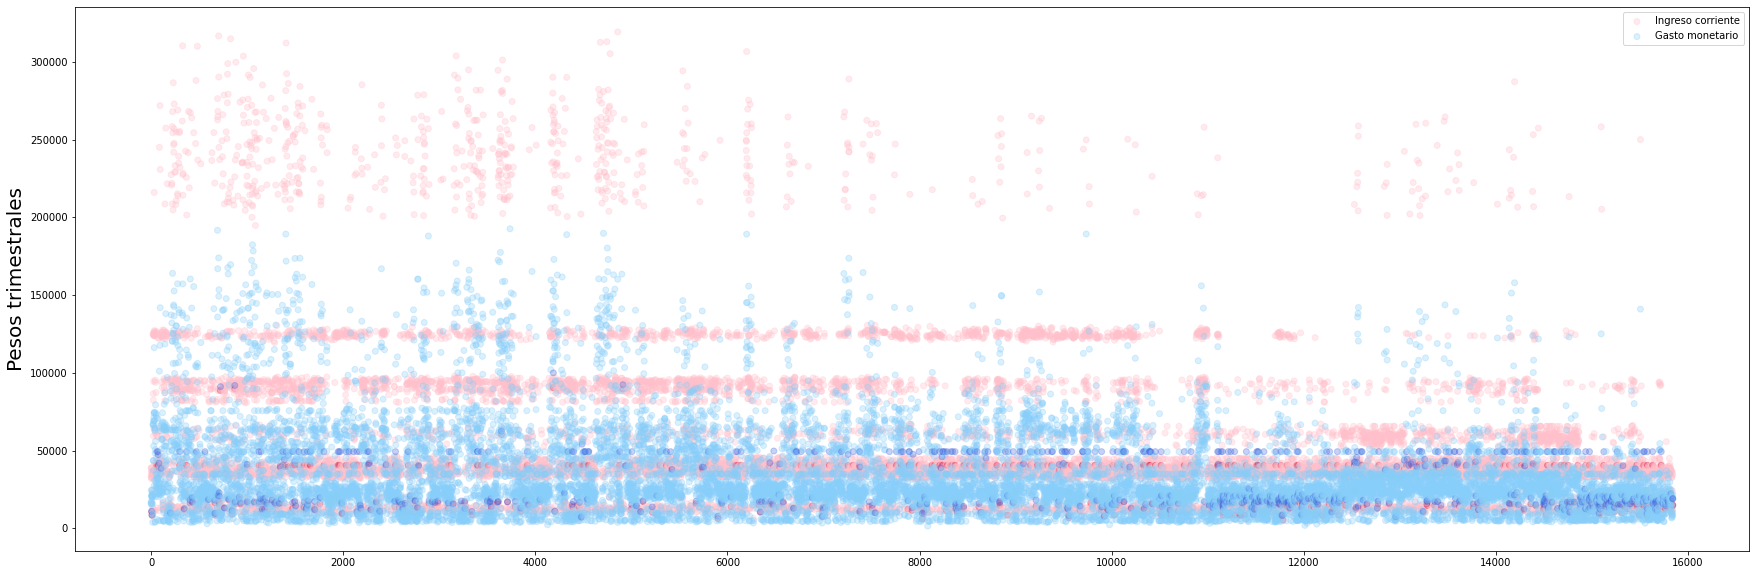

In [122]:
x0 = list(range(censo2.shape[0]))

plt.figure(figsize=(30, 10))
plt.scatter(x0, censo2['ing_cor'], color = censo2['ing_gasto'].replace({0:'pink', 1:'crimson'}), alpha=0.3, label="Ingreso corriente")
plt.scatter(x0, censo2['gasto_mon'], color = censo2['ing_gasto'].replace({0:'lightskyblue', 1:'royalblue'}), alpha=0.3, label="Gasto monetario")
plt.ylabel("Pesos trimestrales", size=20)
plt.legend(loc='upper right')
plt.show()

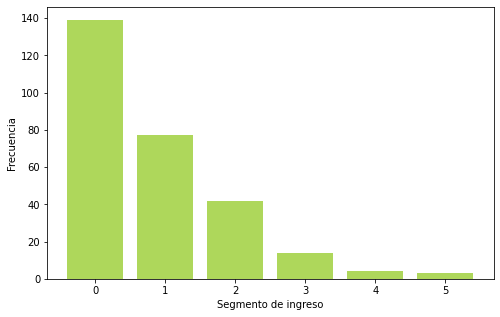

In [123]:
a = enigh.loc[enigh['ing_gasto']==1, 'ing_cor_segment'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(a.index, a.values, linewidth=25, color = 'yellowgreen', alpha = 0.8)
plt.xticks(a.index)
plt.xlabel('Segmento de ingreso')
plt.ylabel('Frecuencia')
plt.show()

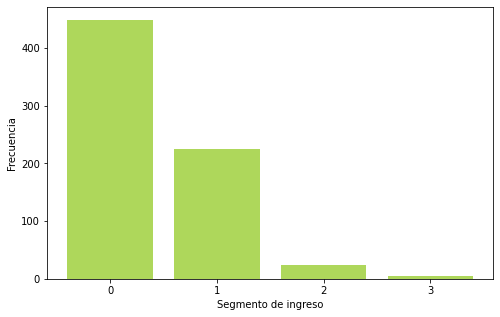

In [124]:
a = censo2.loc[censo2['ing_gasto']==1, 'ing_cor_t_segment'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(a.index, a.values, linewidth=25, color = 'yellowgreen', alpha = 0.8)
plt.xticks(a.index)
plt.xlabel('Segmento de ingreso')
plt.ylabel('Frecuencia')
plt.show()

### Total expenditure and income as the sum of their components

In [125]:
difingcor = enigh['ing_cor']-enigh['ingtrab']-enigh['rentas']-enigh['transfer']-enigh['estim_alqu']-enigh['otros_ing']
print('Enigh income difference:', difingcor.mean()/3, difingcor.max()/3, difingcor.std()/3)

difingcor = censo2['ing_cor']-censo2['ingtrab']-censo2['rentas']-censo2['transfer']-censo2['estim_alqu']-censo2['otros_ing']
print('Income difference in Pangea:', difingcor.mean()/3, difingcor.max()/3, difingcor.std()/3)

Diferencia de ingreso Enigh: -2.0020462176345976e-14 9.701276818911234e-12 1.5576009002635698e-12
Diferencia de ingreso en Pangea: -483.74740713349996 13422.305211340856 7588.299675921319


In [126]:
difgasto = enigh['gasto_mon']-enigh['alimentos']-enigh['vesti_calz']-enigh['vivienda']-enigh['limpieza']-enigh['salud']-enigh['transporte']-enigh['educa_espa']-enigh['personales']-enigh['transf_gas']
print('Enigh income difference:', difgasto.mean()/3,difgasto.std()/3,difgasto.max()/3)

difgasto = censo2['gasto_mon']-censo2['alimentos']-censo2['vesti_calz']-censo2['vivienda']-censo2['limpieza']-censo2['salud']-censo2['transporte']-censo2['educa_espa']-censo2['personales']-censo2['transf_gas']
print('Pangea Income Difference:', difgasto.mean()/3,difgasto.std()/3,difgasto.max()/3)

Diferencia de ingreso Enigh: 2.257484826663902e-14 1.3321511048764847e-12 1.2126596023639044e-11
Diferencia de ingreso Pangea: -191.551552974589 5746.450781745847 10795.362612213396


In [127]:
difalim = enigh['ali_dentro']-enigh['cereales']-enigh['carnes']-enigh['pescado']-enigh['leche']-enigh['huevo']-enigh['aceites']-enigh['tuberculo']-enigh['verduras']-enigh['frutas']-enigh['azucar']-enigh['cafe']-enigh['especias']-enigh['otros_alim']-enigh['bebidas']
print('Difference of food inside Enigh:', difalim.mean()/3, difalim.std()/3, difalim.max()/3)

difalim = censo2['ali_dentro']-censo2['cereales']-censo2['carnes']-censo2['pescado']-censo2['leche']-censo2['huevo']-censo2['aceites']-censo2['tuberculo']-censo2['verduras']-censo2['frutas']-censo2['azucar']-censo2['cafe']-censo2['especias']-censo2['otros_alim']-censo2['bebidas']
print('Difference of food inside real:', difalim.mean()/3, difalim.std()/3, difalim.max()/3)

Diferencia de alimento dentro Enigh: 2.6186487273142954e-14 3.862718356081899e-13 3.637978807091713e-12
Diferencia de alimento dentro real: 219.7034994581738 879.1540625497338 1706.4910449872489


## Comparing current income segments

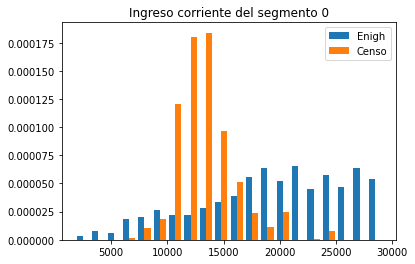

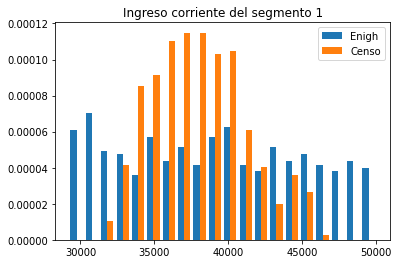

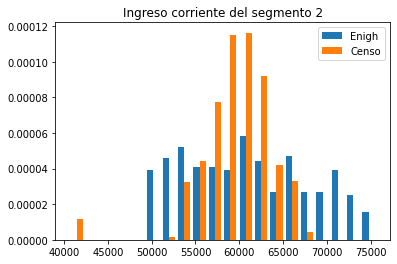

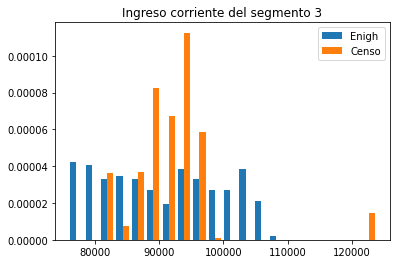

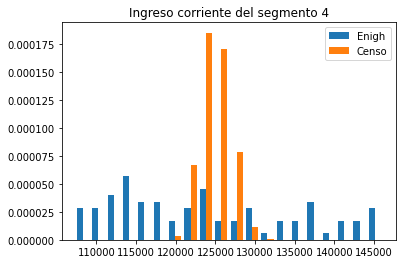

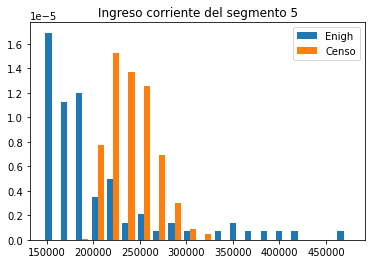

In [128]:
for i in range(6):
  plt.hist([enigh.loc[enigh['ing_cor_segment']==i, 'ing_cor'], censo2.loc[censo2['tapestry'].str[0]==str(i), 'ing_cor']], label=['Enigh', 'Censo'], bins=20, density=True)
  plt.title('Ingreso corriente del segmento '+str(i))
  plt.legend(loc='upper right')
  plt.show()

### Calculating the metrics (all variables) Pondera

In [129]:
var = ['ing_cor', 'ingtrab', 'rentas', 'transfer', 'estim_alqu', 'otros_ing',
       'gasto_mon', 'alimentos', 'vesti_calz', 'vivienda', 'limpieza', 'salud', 'transporte', 'educa_espa', 'personales', 'transf_gas',
       'ali_dentro', 'pago_tarje']

nclasses = 6

for j in var:
  print(j)
  xt = enigh[j].values
  breaks = jenkspy.jenks_breaks(xt, nclasses)
  breaks = np.array(breaks)
  
  # Segmentation
  enigh[j+'_segment'] = enigh[j].apply(find_segment,args=(breaks,))
  censo2[j+'_segment'] = censo2[j].apply(find_segment,args=(breaks,))

  # data base segmentation variables
  censo_pred = (censo2[j+'_segment'].value_counts(normalize=True)*100).sort_index()
  enigh_true = (enigh[j+'_segment'].value_counts(normalize=True)*100).sort_index()
  censo_pred.columns = ['Censo']
  enigh_true.columns = ['Enigh']
  censo_pred = pd.DataFrame(censo_pred).reset_index()
  enigh_true = pd.DataFrame(enigh_true).reset_index()

  temp = pd.DataFrame({'index':np.arange(6)})

  temp = temp.merge(censo_pred, how='left', on='index')
  temp = temp.merge(enigh_true, how='left', on='index')

  temp = temp.fillna(0)


  met = []
  for k in range(6):
      met.append((temp.loc[k, j+'_segment_y']-temp.loc[k, j+'_segment_x'])/(temp.loc[k, j+'_segment_y']+temp.loc[k, j+'_segment_x']))
      print('Segment metric', k,':', met[k])

  val=0
  for k in range(6):
      val = val + np.abs(met[k])
  print('Generarl metric:', val/6)

  val=0
  for k in range(6):
      val = val + np.abs(met[k])*(temp.loc[k, j+'_segment_y']/temp[j+'_segment_y'].sum())
  print('Balanced metric:', val, '\n')

ing_cor
Métrica segmento 0 : -0.1101505206014843
Métrica segmento 1 : 0.11172507002061459
Métrica segmento 2 : 0.11913673749792625
Métrica segmento 3 : -0.03014424799039725
Métrica segmento 4 : -0.13202120228458725
Métrica segmento 5 : 0.23721593934359894
Métrica general: 0.12339895295643477
Métrica balanceada: 0.10832337076817027 

ingtrab
Métrica segmento 0 : 0.09177327343265804
Métrica segmento 1 : -0.16379863744764778
Métrica segmento 2 : 0.30391702579176755
Métrica segmento 3 : -0.06383317100397541
Métrica segmento 4 : -0.05344286781179988
Métrica segmento 5 : -0.1298322058567754
Métrica general: 0.13443286355743736
Métrica balanceada: 0.15965863043460715 

rentas
Métrica segmento 0 : -0.001039541759031575
Métrica segmento 1 : 0.3323062797776601
Métrica segmento 2 : -0.33405631707040256
Métrica segmento 3 : -0.6070713759570241
Métrica segmento 4 : 0.2849669491869094
Métrica segmento 5 : 1.0
Métrica general: 0.4265734106251713
Métrica balanceada: 0.019843162423618655 

transfer
Mét

### Graphs of current income and monetary expenditure

In [132]:
muns = ['001']

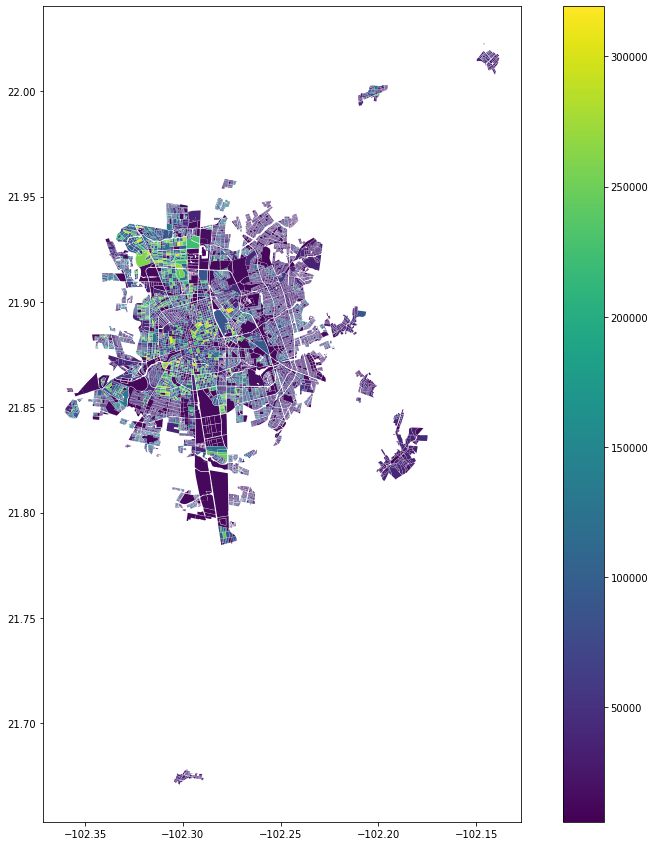

In [133]:
estado_ = '0'+str(estado) if estado<10 else str(estado)
shp = gpd.read_file(f'/content/gdrive/MyDrive/pamgea3_0/shape_estados/{estado_}m.shp')
shp.to_crs('EPSG:4326',inplace=True)

if len(muns)>0:
    shp = shp[shp['CVE_MUN'].isin(muns)].reset_index(drop=True)
    
shp = shp.merge(censo2[['CVEGEO', 'ing_cor', 'gasto_mon']], left_on='CVEGEO',right_on='CVEGEO')
base = shp.plot(column='ing_cor',figsize=[15,15],legend=True)

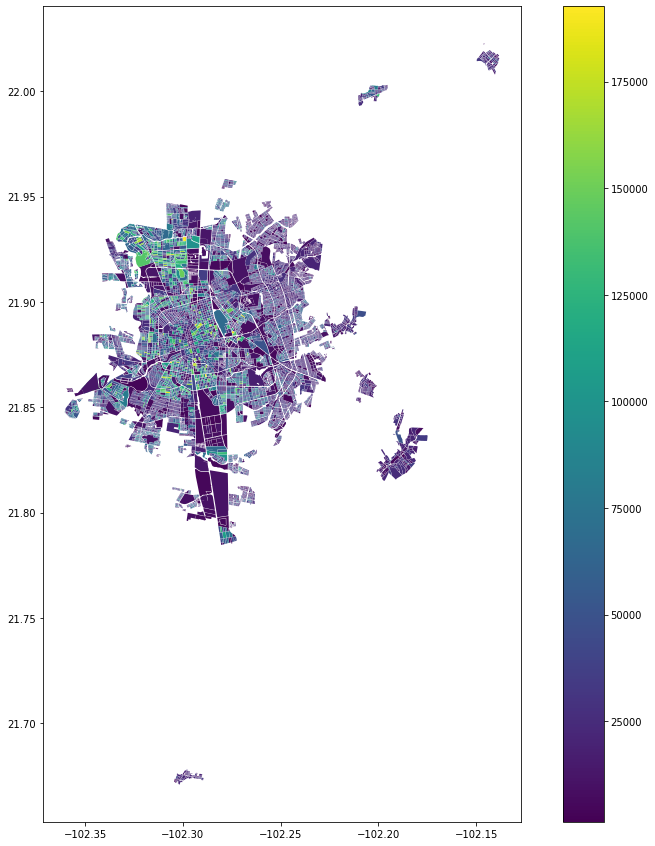

In [134]:
shp.plot(column='gasto_mon',figsize=[15,15],legend=True)